# The system

In [254]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, KNNBasic


## Part 1: Data Preparation
### Including: Data Retrieval, Exploratory Data Analysis (EDA), Data Cleaning, & Feature Engineering

In [255]:
books = pd.read_csv("../data/user_data/Books.csv", low_memory=False)
ratings = pd.read_csv("../data/user_data/Ratings.csv")
users = pd.read_csv("../data/user_data/Users.csv")
goodreads = pd.read_csv("../data/goodreads_data.csv")

In [256]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [257]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [258]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [259]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [260]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [261]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [262]:
goodreads.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


In [263]:
goodreads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   10000 non-null  int64  
 1   Book         10000 non-null  object 
 2   Author       10000 non-null  object 
 3   Description  9923 non-null   object 
 4   Genres       10000 non-null  object 
 5   Avg_Rating   10000 non-null  float64
 6   Num_Ratings  10000 non-null  object 
 7   URL          10000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [264]:
goodreads[goodreads['Description'].isna()]

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
1066,1066,A Decade of Desire: Erotic Tales from the Char...,Charles Dyson,NaN,"['Contemporary', 'Epic', 'Romance', 'Erotica']",4.34,730,https://www.goodreads.com/book/show/57601103-a...
1224,1224,"Complicated Moonlight (DCYE, #2)",Lynessa Layne,NaN,"['Romance', 'Reverse Harem']",4.29,234,https://www.goodreads.com/book/show/55196363-c...
1745,1745,"Mad Love (DCYE, #3)",Lynessa Layne,NaN,"['Reverse Harem', 'Romance']",4.23,147,https://www.goodreads.com/book/show/55961601-m...
2104,2104,The Spirit of Prayer: The Believer's Authority...,Tolulope Oyewole,NaN,"['Contemporary', 'Novels']",4.45,201,https://www.goodreads.com/book/show/57392898-t...
2270,2270,Lift: Five Practices Great Managers Do Consist...,Raymond Wheeler,NaN,"['Nonfiction', 'How To', 'Business', 'Self Hel...",4.30,125,https://www.goodreads.com/book/show/55455888-lift
...,...,...,...,...,...,...,...,...
9746,9746,You'll Need a Guardian Angel,Victor Piasecki,NaN,[],3.83,6,https://www.goodreads.com/book/show/5011514-yo...
9806,9806,A Touch Of Greatness,Frank Tibolt,NaN,[],4.00,13,https://www.goodreads.com/book/show/5023105-a-...
9834,9834,Mireasma trandafirilor salbatici,Sorina Popescu,NaN,['Romanian Literature'],4.64,14,https://www.goodreads.com/book/show/18247028-m...
9850,9850,Iron Butterfly: A Novel of Africa,Clara Whaley Perkins,NaN,[],3.83,6,https://www.goodreads.com/book/show/14404443-i...


In [265]:
print("Goodreads:", goodreads.shape)
print("Books:", books.shape)
print("Users:", users.shape)
print("Ratings:", ratings.shape)

Goodreads: (10000, 8)
Books: (271360, 8)
Users: (278858, 3)
Ratings: (1149780, 3)


#### Cleaning the Goodreads.csv dataset

In [266]:
#The Goodreads dataset has the Genre column as a string
#Converting it to a list

goodreads['Genres'] = goodreads['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else[])

In [267]:
#Remove the index that came with the dataset

goodreads = goodreads.drop(columns=["Unnamed: 0"])

In [268]:
#Description has 77 missing values
#I do not want to remove those rows because I want to keep the 77 books listed in those rows
#Replacing the missing Descriptions with an empty string as it will be helpful later on

goodreads['Description'] = goodreads['Description'].fillna("")

In [269]:
#Normalize author names and book titles

goodreads['Author'] = goodreads['Author'].str.strip().str.title()
goodreads['Book'] = goodreads['Book'].str.strip().str.title()

In [270]:
goodreads.head()

#Looks good

,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,To Kill A Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"[Classics, Fiction, Historical Fiction, School...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,Harry Potter And The Philosopher’S Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"[Fantasy, Fiction, Young Adult, Magic, Childre...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,Pride And Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","[Classics, Fiction, Romance, Historical Fictio...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,The Diary Of A Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"[Classics, Nonfiction, History, Biography, Mem...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"[Classics, Fiction, Dystopia, Fantasy, Politic...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


#### Now the Books.csv dataset

In [271]:
#Fix column names

books.columns = books.columns.str.replace("-","_").str.replace(" ", "_")

In [272]:
#Remove invalid publication years

before = books.shape[0]

books['Year_Of_Publication'] = pd.to_numeric(books['Year_Of_Publication'], errors='coerce')
books = books[(books['Year_Of_Publication'] >=1800) & (books['Year_Of_Publication']<= 2025)]

after = books.shape[0]

print(f"Rows removed: {before-after}")

Rows removed: 4635


In [273]:
#Normalize book author and book titles

books['Book_Author'] = books['Book_Author'].str.strip().str.title()
books['Book_Title'] = books['Book_Title'].str.strip().str.title()

In [274]:
books.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision In Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story Of The Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies Of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [275]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266725 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 266725 non-null  object 
 1   Book_Title           266725 non-null  object 
 2   Book_Author          266723 non-null  object 
 3   Year_Of_Publication  266725 non-null  float64
 4   Publisher            266723 non-null  object 
 5   Image_URL_S          266725 non-null  object 
 6   Image_URL_M          266725 non-null  object 
 7   Image_URL_L          266725 non-null  object 
dtypes: float64(1), object(7)
memory usage: 18.3+ MB


In [276]:
books[books['Book_Author'].isna()]


,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide To Managing Your Perso...,NaN,1995.0,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [277]:
#Dropping those two rows because they do not matter

books = books.dropna(subset=["Book_Author"])

In [278]:
books[books['Publisher'].isna()]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [279]:
#Also dropping those two rows because they do not matter

books = books.dropna(subset=["Publisher"])

In [280]:
books.info()

#Im happy with that, let's move on

<class 'pandas.core.frame.DataFrame'>
Index: 266721 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 266721 non-null  object 
 1   Book_Title           266721 non-null  object 
 2   Book_Author          266721 non-null  object 
 3   Year_Of_Publication  266721 non-null  float64
 4   Publisher            266721 non-null  object 
 5   Image_URL_S          266721 non-null  object 
 6   Image_URL_M          266721 non-null  object 
 7   Image_URL_L          266721 non-null  object 
dtypes: float64(1), object(7)
memory usage: 18.3+ MB


#### Cleaning the Ratings.csv dataset

In [281]:
#Looking at the distribution of ratings

ratings['Book-Rating'].value_counts().sort_index()

Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64

In [282]:
#Dropping rows with rating = 0
#Those are instances where users clicked or viewed on the book but did not give a rating.
#Keeping the zeros will distort the algorithm 

#The dataset will still have ~400k+ ratings amount ~100k users that cover ~100k books

ratings['Book-Rating'] = pd.to_numeric(ratings['Book-Rating'], errors='coerce')
ratings = ratings[ratings['Book-Rating'] >0]

In [283]:
ratings['Book-Rating'].value_counts().sort_index()

Book-Rating
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64

In [284]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433671 entries, 1 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB


In [285]:
#Fix column names

ratings.columns = ratings.columns.str.replace("-","_").str.replace(" ", "_")

In [286]:
ratings.head()

,User_ID,ISBN,Book_Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


#### Lastly, let's clean the Users.csv dataset

In [287]:
#Dropping Age column as it is really messy and not relevant to the system

users = users.drop(columns=['Age'])

In [288]:
#Fix column names

users.columns = users.columns.str.replace("-","_").str.replace(" ", "_")

In [289]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   User_ID   278858 non-null  int64 
 1   Location  278858 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


In [290]:
#I did not anticpate using User Location as part of the system
#However, now I think it would be an interesting addition
#But only at the high level - by country

users['Country'] = users['Location'].str.split(",").str[-1].str.strip().str.lower()

In [291]:
users.head()

,User_ID,Location,Country
0,1,"nyc, new york, usa",usa
1,2,"stockton, california, usa",usa
2,3,"moscow, yukon territory, russia",russia
3,4,"porto, v.n.gaia, portugal",portugal
4,5,"farnborough, hants, united kingdom",united kingdom


In [292]:
users['Country'].value_counts().sort_values(ascending=False)

Country
usa                139711
canada              21658
united kingdom      18538
germany             17043
spain               13147
                    ...  
rep. san marino         1
r.o.c.                  1
victoria                1
bkk                     1
united kingdom.         1
Name: count, Length: 709, dtype: int64

In [293]:
#Normalize Country

users['Country'] = users['Country'].astype(str).str.lower().str.strip()

In [294]:
#Remove the stray quotes

users['Country'] = (
    users['Country']
    .str.replace('"', '', regex=False)
    .str.replace("'","", regex=False)
    .str.strip()
)

In [295]:
#Convert the blank or whitespace entries to NaN

users['Country'] = users['Country'].replace(r'^\s*$', pd.NA, regex=True)

#Convert "n/a", "na", or "none" to NaN

users['Country'] = users['Country'].replace(["n/a", "na", "none"], pd.NA)

#Filling all of the NaN as "other" so there are no missing values
users['Country']= users['Country'].fillna("other")

In [296]:
#Used ChatGPT here to find the countries that are in the native language and not English
#It included the fixes for "usa" without a specific prompt for that

country_replacements = {
    "la france": "france",
    "litalia": "italy",
    "l'italia": "italy",
    "l’italia": "italy",
    "espana": "spain",
    "deutschland": "germany",
    "suisse": "switzerland",
    "svizzera": "switzerland",
    "schweiz": "switzerland",
    "united staes": "usa",
    "united stated of america": "usa",
    "u.s.a": "usa",
    "u.s.a.": "usa",
    "españa": "spain",
    "urugua": "uruguay",
    "u.a.e": "united arab emirates",
    "l`italia": "italy",
    "england": "united kingdom",
    "scotland": "united kingdom",
    "wales": "united kingdom",
    "p r china": "china",
    "people`s republic of china": "china",
    "united kingdom.": "united kingdom",
    "burma": "myanmar",
}

users['Country'] = users['Country'].replace(country_replacements)

In [297]:
#Grouping the countries with less than 20 users as "other"
#Most of those in this list are not a country, or is gibberish

country_counts = users['Country'].value_counts()
valid_countries = country_counts[country_counts >= 20].index

users['Country_clean'] = users ['Country'].apply(
    lambda x: x if x in valid_countries else "other"
)

In [298]:
#I ran that list through ChatGPT again and it suggested fixing the following list as well
#I am adding them to "other"

territories_to_other = [
    "antarctica",
    "bermuda",
    "puerto rico",
    "hong kong",
    "macedonia",
    "yugoslavia",
]

users['Country_clean'] = users['Country_clean'].replace(
    territories_to_other, "other"
)

In [299]:
#Grouping again

country_counts = users['Country_clean'].value_counts()
valid_countries = country_counts[country_counts >= 20].index

users['Country_clean'] = users['Country_clean'].apply(
    lambda x: x if x in valid_countries else "other"
)

In [300]:
users['Country_clean'].value_counts()

Country_clean
usa               139715
canada             21658
united kingdom     18636
germany            17102
spain              13322
                   ...  
belize                23
jordan                22
estonia               22
nepal                 21
mauritius             21
Name: count, Length: 98, dtype: int64

In [301]:
#Looks good so let's drop the old Country column

users = users.drop(columns=['Country'])


#Lets also drop the Location column

users = users.drop(columns=('Location'))

In [302]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User_ID        278858 non-null  int64 
 1   Country_clean  278858 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


### Moving on to EDA

In [303]:
print("Books:", books.shape)
print("Ratings:", ratings.shape)
print("Users:", users.shape)
print("Goodreads:", goodreads.shape)

Books: (266721, 8)
Ratings: (433671, 3)
Users: (278858, 2)
Goodreads: (10000, 7)


<Axes: >

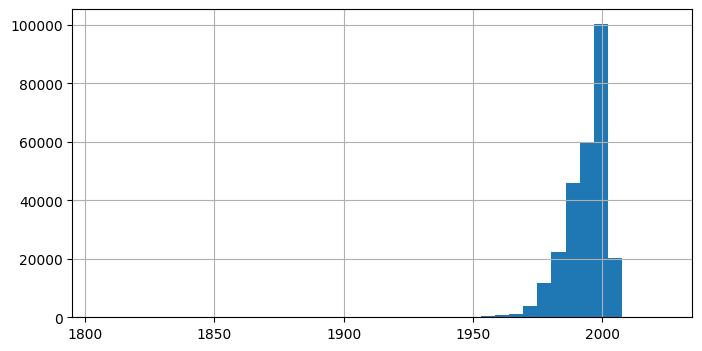

In [304]:
#Checking Publication Date for Outliers

books['Year_Of_Publication'].hist(bins=40, figsize=(8,4))

In [305]:
#As expected, there are outliers.
#Getting rid of rows with books published before 1950 for relevancy

books['Year_Of_Publication']= books['Year_Of_Publication'].clip(lower=1950,upper=2024)

<Axes: >

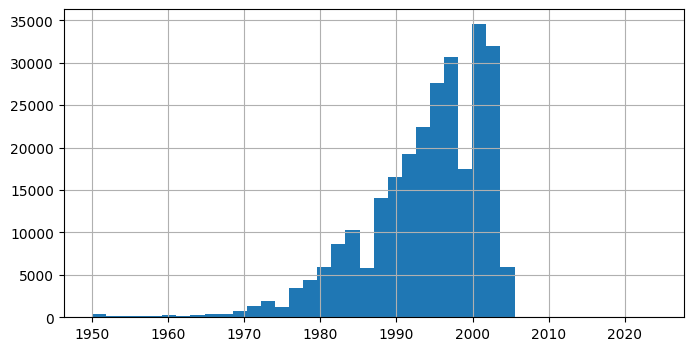

In [306]:
books['Year_Of_Publication'].hist(bins=40, figsize=(8,4))

#Looks much better

In [307]:
#Top 10 authors from Amazon

books['Book_Author'].value_counts().head(10)

Book_Author
Agatha Christie        602
William Shakespeare    562
Stephen King           521
Ann M. Martin          423
Francine Pascal        419
Carolyn Keene          372
Isaac Asimov           342
Nora Roberts           317
Barbara Cartland       308
Charles Dickens        300
Name: count, dtype: int64

In [308]:
#Top 10 Authors from Goodreads

goodreads['Author'].value_counts().head(10)

Author
Stephen King           57
William Shakespeare    39
Terry Pratchett        35
Agatha Christie        33
Anonymous              28
Rick Riordan           26
John Grisham           23
Julie Mannino          22
Lucian Bane            22
C.S. Lewis             20
Name: count, dtype: int64

In [309]:
#Top 10 Publishers from Amazon

books['Publisher'].value_counts().head(10)

Publisher
Harlequin                   7535
Silhouette                  4220
Pocket                      3870
Ballantine Books            3764
Bantam Books                3642
Scholastic                  3157
Simon &amp; Schuster        2965
Penguin Books               2843
Berkley Publishing Group    2767
Penguin USA                 2714
Name: count, dtype: int64

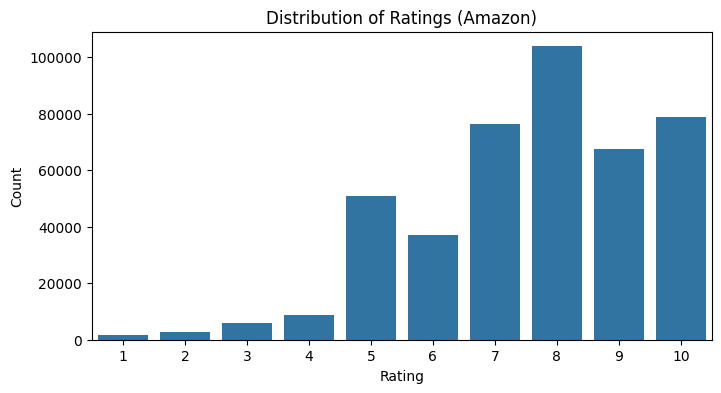

In [310]:
#Plot for distribution of Ratings for Amazon

rating_counts = ratings['Book_Rating'].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings (Amazon)")
plt.show()

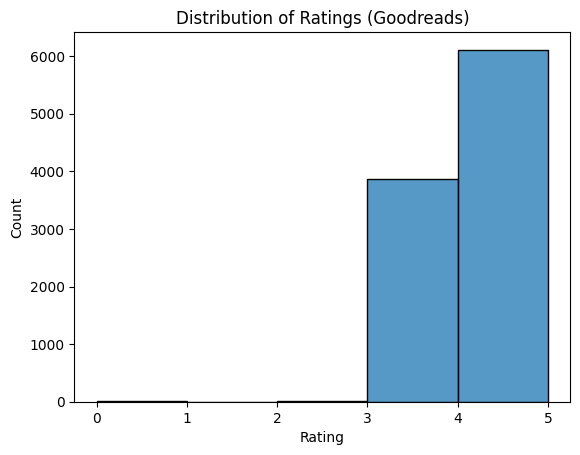

In [311]:
#Plot for distribution of Ratings for Goodreads

sns.histplot(goodreads['Avg_Rating'], bins=5)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings (Goodreads)")
plt.show()

In [312]:
#Number of ratings per user

ratings['User_ID'].value_counts().describe()

#This is highly skewed

count    77805.000000
mean         5.573819
std         44.001879
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8524.000000
Name: count, dtype: float64

In [313]:
#I am worried the users that have contributed thousands of rankings will give bias to the model

ratings['User_ID'].value_counts().head(10)

#However, the system will be able to give better matches to users with more ratings
#Keeping them for now

User_ID
11676     8524
98391     5802
153662    1969
189835    1906
23902     1395
76499     1036
171118    1035
235105    1023
16795      968
248718     948
Name: count, dtype: int64

In [314]:
#Ratings per book

ratings['ISBN'].value_counts().describe()

#While 707 ratings for one book is an outlier, it is not an error
#More popular books will have more rating

count    185973.000000
mean          2.331903
std           6.834667
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: count, dtype: float64

In [315]:
#Percentage of users from top 5 countries

top5= users['Country_clean'].value_counts().head(5)
(top5.sum()/ len(users)) *100

75.46242173435942

In [316]:
#Counting genres from Goodreads data

genre_counts = Counter()

for g in goodreads['Genres']:
    if isinstance(g, list):
        genre_counts.update(g)

pd.Series(genre_counts).sort_values(ascending=False).head(20)

Fiction               5700
Nonfiction            2330
Fantasy               2195
Classics              2123
Romance               1558
Young Adult           1522
Historical Fiction    1481
Mystery               1357
Contemporary          1302
Audiobook             1242
Novels                1164
Literature            1110
Thriller              1021
Historical             942
Science Fiction        845
History                819
Adventure              749
Philosophy             742
Biography              721
Self Help              713
dtype: int64

In [317]:
#Checking that all ISBNs in the ratings data also exists in the books data

missing_books = ~ratings['ISBN'].isin(books['ISBN'])
missing_books.sum()

#55,642 ratings reference ISBNs that are not in the books data
#This a problem for when I merge the data, as the ISBNs not in the books data will not have any metadata

55643

In [318]:
#Removing the ratings with ISBN's that are not in the books data

ratings_clean = ratings[ratings['ISBN'].isin(books['ISBN'])]

In [319]:
#Now books and ratings data are ready to merge

ratings_merged = ratings_clean.merge(
    books,
    on='ISBN',
    how='inner'
)

ratings_merged.head()

,User_ID,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
0,276726,0155061224,5,Rites Of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,A Painted House,John Grisham,2001.0,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...


In [320]:
print("Ratings Merged:", ratings_merged.shape)

ratings_merged.info()

Ratings Merged: (378028, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378028 entries, 0 to 378027
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_ID              378028 non-null  int64  
 1   ISBN                 378028 non-null  object 
 2   Book_Rating          378028 non-null  int64  
 3   Book_Title           378028 non-null  object 
 4   Book_Author          378028 non-null  object 
 5   Year_Of_Publication  378028 non-null  float64
 6   Publisher            378028 non-null  object 
 7   Image_URL_S          378028 non-null  object 
 8   Image_URL_M          378028 non-null  object 
 9   Image_URL_L          378028 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 28.8+ MB


In [321]:
#Removing duplicate ratings as a sanity check

ratings_merged.drop_duplicates(['User_ID', 'ISBN'], keep='first', inplace=True)

ratings_merged.info()

#There were none

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378028 entries, 0 to 378027
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_ID              378028 non-null  int64  
 1   ISBN                 378028 non-null  object 
 2   Book_Rating          378028 non-null  int64  
 3   Book_Title           378028 non-null  object 
 4   Book_Author          378028 non-null  object 
 5   Year_Of_Publication  378028 non-null  float64
 6   Publisher            378028 non-null  object 
 7   Image_URL_S          378028 non-null  object 
 8   Image_URL_M          378028 non-null  object 
 9   Image_URL_L          378028 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 28.8+ MB


## Part 2: Recommendation System



In [322]:
#Filter books with enough ratings
#The CF KNN model will perform better

book_counts = ratings_merged['ISBN'].value_counts()
valid_books = book_counts[book_counts >= 5].index

ratings_filt = ratings_merged[ratings_merged['ISBN'].isin(valid_books)]

In [323]:
#Filter users with enough ratings
#Again, the CF KNN model will perform better

user_counts = ratings_filt['User_ID'].value_counts()
valid_users = user_counts[user_counts >= 5].index

ratings_filt= ratings_filt[ratings_filt['User_ID'].isin(valid_users)]

#### Create Modeling Matrices

In [324]:
#User-Item Rating Matrix
#For Collaborative Filtering

user_ids_f = ratings_filt['User_ID'].astype('category').cat.codes
book_ids_f = ratings_filt['ISBN'].astype('category').cat.codes
ratings_vals_f = ratings_filt['Book_Rating'].astype(float).values

user_item_sparse_f = csr_matrix(
    (ratings_vals_f, (user_ids_f, book_ids_f))
)

user_item_sparse_f

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 132196 stored elements and shape (7676, 13500)>

In [325]:
#Checking sparsity

print("shape:", user_item_sparse_f.shape)
print("nonzero entries:", user_item_sparse_f.count_nonzero())
print("sparsity:", 1 - (user_item_sparse_f.count_nonzero()/ np.prod(user_item_sparse_f.shape)))

shape: (7676, 13500)
nonzero entries: 132196
sparsity: 0.9987242969911027


In [326]:
#Build an indexed version of books

isbn_filt = ratings_filt['ISBN'].unique()

books_indexed = books.drop_duplicates('ISBN').set_index('ISBN')

books_indexed.head()

,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
ISBN,,,,,,,
0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
0060973129,Decision In Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
0374157065,Flu: The Story Of The Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
0393045218,The Mummies Of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [327]:
#Select only books used in ratings
#Return ISBN as a column

books_for_model = books_indexed.loc[isbn_categories].reset_index().rename(columns={'index':'ISBN'})

books_for_model['Book_Title'] = books_for_model['Book_Title'].fillna('')
books_for_model['Book_Author'] = books_for_model['Book_Author'].fillna('')
books_for_model['Publisher'] = books_for_model['Publisher'].fillna('')

books_for_model['text'] =(
    books_for_model['Book_Title'] +''+
    books_for_model['Book_Author'] +''+
    books_for_model['Publisher']
)

books_for_model[['ISBN', 'text']].head()

,ISBN,text
0,0000913154,The Way Things Work: An Illustrated Encycloped...
1,000104687X,"T.S. Eliot Reading \The Wasteland\"" And Other ..."
2,0001047213,The Fighting ManGerald SeymourHarperCollins Pu...
3,0001047973,Brave New WorldAldous HuxleyTrafalgar Square P...
4,000104799X,Monk'S-HoodEllis PetersHarperCollins Publishers


In [328]:
#Build TF-IDF Matrix
#Limiting vocab size to prevent memory explosion

tfidf = TfidfVectorizer(
    max_features=20000,
    stop_words='english',
    ngram_range=(1,2),
    min_df=2,
    strip_accents='unicode'
)

tfidf_matrix = tfidf.fit_transform(books_for_model['text'])

tfidf_matrix.shape

(147100, 20000)

#### Build the Content-Based Recommender

In [329]:
#Creating an easy way to find ISBN to row index

isbn_to_index = pd.Series(books_for_model.index, index=books_for_model['ISBN'])

In [330]:
#Inspect top TF-IDF term

feature_names = tfidf.get_feature_names_out()

term_weights = tfidf_matrix.sum(axis=0).A1

N = 20 
top_idx = term_weights.argsort()[::-1][:N]

top_terms = [(feature_names[i], term_weights[i]) for i in top_idx]

top_terms

[('books', 7668.58176463422),
 ('press', 2788.2648697285194),
 ('publishing', 2294.837164262635),
 ('amp', 2080.734873459544),
 ('book', 1792.6830449217566),
 ('house', 1589.6846498369134),
 ('group', 1463.4965389737563),
 ('pub', 1326.7823444799587),
 ('company', 1169.7656078966297),
 ('publishers', 1057.8865444553012),
 ('usa', 1012.6744120718379),
 ('publishing group', 868.4903097224795),
 ('library', 812.8685048889146),
 ('life', 761.8009550178558),
 ('guide', 727.6926140731866),
 ('la', 718.7099219181264),
 ('martin', 704.5544768661539),
 ('love', 697.0636769996385),
 ('pr', 685.0458614566766),
 ('publishing company', 671.6930136190861)]

In [331]:
#Recommender function 

def recommend_content(isbn, top_n=10):
    idx = isbn_to_index [isbn]
    
    book_vec = tfidf_matrix[idx]
    
    sims = cosine_similarity(book_vec, tfidf_matrix).flatten()
    
    similar_idx = sims.argsort()[::-1][1:top_n+1]
    
    results = books_for_model.iloc[similar_idx][['ISBN', 'Book_Title', 'Book_Author']].copy()

    results['similarity'] = sims[similar_idx]
    
    return results.reset_index(drop=True)

In [332]:
#Test the recommender

sample_isbn = books_for_model['ISBN'].iloc[0]
recommend_content(sample_isbn)

,ISBN,Book_Title,Book_Author,similarity
0,0821225065,The Bulfinch Illustrated Encyclopedia Of Antiques,Lars Tharp,0.569961
1,0747204020,Illustrated Encyclopedia Of Cacti,Glass Charles,0.569961
2,0671508164,The Simon &Amp; Schuster Young Readers' Illust...,George Beal,0.543838
3,0785811060,The New Illustrated Encyclopedia Of Automobiles,David Burgess Wise,0.535391
4,0138137676,Simon &Amp; Schuster Handbook For Writers,Lynn Quitman Troyka,0.506556
5,0586080953,How Things Work: The Universal Encyclopedia Of...,C. Van Amerongen (Translator),0.483920
6,0671491709,Simon &Amp; Schuster'S Guide To Cats,Gino Pugnetti,0.473118
7,0671255274,Simon &Amp; Schuster'S Guide To Dogs,Gino Pugnetti,0.473118
8,087596964X,Rodale'S Illustrated Encyclopedia Of Herbs,Claire Kowalchik,0.464498
9,0671631314,Simon &Amp; Schuster'S Guide To House Plants,Allessandro B. Chiulosi,0.461425


#### Collaborative Filtering Model

In [333]:
#Using surprise library
#It was specifically built for CF recommender systems

reader = Reader(rating_scale=(1,10))

data = Dataset.load_from_df(
    ratings_filt[['User_ID', 'ISBN', 'Book_Rating']],
    reader
)

trainset = data.build_full_trainset()

In [334]:
#Train an item-based cosine KNN model

sim_options = {
    'name': 'cosine',
    'user_based': False
}

algo = KNNBasic(sim_options= sim_options)
trainset = data.build_full_trainset()
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [335]:
#Create mapping of ISBN to surprise internal ID

surprise_isbns = {trainset.to_raw_iid(iid) for iid in trainset.all_items()}

isbn_to_inner = {
    raw: trainset.to_inner_iid(raw)
    for raw in surprise_isbns
}

In [336]:
#Recommendation function
#Given an ISBN -> recommend similar books -> based on user rating patterns

def recommend_cf(isbn, top_n =10):
    if isbn not in isbn_to_inner:
        return f"ISBN {isbn} has no user ratings"
    
    inner_id = isbn_to_inner[isbn]

    neighbors_inner = algo.get_neighbors(inner_id, k=top_n)

    neighbor_isbns = [trainset.to_raw_iid(n) for n in neighbors_inner]

    recs = books_indexed.loc[neighbor_isbns][['Book_Title', 'Book_Author']].copy()
    recs = recs.reset_index().rename(columns={'index': 'ISBN'})
   
    return recs

In [337]:
#Test the CF Model

sample_isbn = ratings_filt['ISBN'].iloc[0]
recommend_cf(sample_isbn)

,ISBN,Book_Title,Book_Author
0,3404921178,Nur Der Tod Ist Ohne Makel.,Ann Granger
1,3423071516,Der Kleine Hobbit,J. R. R. Tolkien
2,3442413508,Auf Ehre Und Gewissen. Roman.,Elizabeth George
3,3442435773,Denn Keiner Ist Ohne Schuld.,Elizabeth George
4,3442437717,Asche Zu Asche.,Elizabeth George
5,3442441080,Im Angesicht Des Feindes.,Elizabeth George
6,3442446414,Mit Dem Kã?Â¼Hlschrank Durch Irland.,Tony Hawks
7,3442448530,Die Hirnkã?Â¶Nigin.,Thea Dorn
8,3442449820,Undank Ist Der Vã?Â¤Ter Lohn.,Elizabeth George
9,347354034X,Die Welle,Rhue


In [338]:
#Double checking CF model

sample = ratings_filt['ISBN'].sample(1).iloc[0]
recommend_cf(sample)

,ISBN,Book_Title,Book_Author
0,0380785218,Snow Place To Die : A Bed-And-Breakfast Myster...,Mary Daheim
1,0316601950,The Pilot'S Wife : A Novel,Anita Shreve
2,0446670251,The Virgin Suicides,Jeffrey Eugenides
3,0446603589,Absolute Power,David Baldacci
4,0142001740,The Secret Life Of Bees,Sue Monk Kidd
5,015216250X,So You Want To Be A Wizard: The First Book In ...,Diane Duane
6,0440128994,God Save The Child,Robert B. Parker
7,0671004530,On The Street Where You Live,Mary Higgins Clark
8,0380764008,Grime And Punishment (Jane Jeffry Mysteries (P...,Jill Churchill
9,0804108749,Saint Maybe,Anne Tyler


#### Build Hybrid Recommender
Combination of:

Content-based similarity - TF-IDF + Author + publisher

Collaborative filtering similarity - Surprise item-item cosine

In [339]:
#Get content similarity for a single ISBN

def get_content_similarities(isbn):
    if isbn not in isbn_to_index.index:
        return None
    
    idx = isbn_to_index[isbn]

    book_vec = tfidf_matrix[idx]

    sims = cosine_similarity(book_vec, tfidf_matrix).flatten()
    return sims

In [340]:
#Get CF similarity vector for the same ISBN

def get_cf_similarities(isbn, top_k=50):
    if isbn not in isbn_to_inner:
        return None
    
    inner_id = isbn_to_inner[isbn]

    neighbors_inner = algo.get_neighbors(inner_id, k=top_k)

    sim_vector = np.zeros(len(books_for_model), dtype=float)

    for n in neighbors_inner:
        sim = algo.sim[inner_id, n]
        raw_isbn = trainset.to_raw_iid(n)
    
        if raw_isbn in isbn_to_index.index:
            idx = isbn_to_index[raw_isbn]
            sim_vector[idx] = sim

    return sim_vector

In [341]:
#Hybrid Function

def recommend_hybrid(isbn, top_n=10, alpha=0.6):
    content_sims = get_content_similarities(isbn)
    cf_sims = get_cf_similarities(isbn)

    if content_sims is None and cf_sims is None:
        return f"{isbn} has no similarity data"
    
    if content_sims is None:
        content_sims = np.zeros(len(books_for_model))
    if cf_sims is None:
        cf_sims = np.zeros(len(books_for_model))

    hybrid_sims = alpha * content_sims + (1- alpha) * cf_sims

    if isbn in isbn_to_index.index:
        hybrid_sims[isbn_to_index[isbn]] = 0

    top_idx = hybrid_sims.argsort()[::-1][1: top_n +1]

    results = books_for_model.iloc[top_idx][['ISBN', 'Book_Title', 'Book_Author']].copy()
    results['hybrid_score'] = hybrid_sims[top_idx]

    return results.reset_index(drop=True)

In [342]:
#Test the hybrid model

sample_isbn = ratings_filt['ISBN'].iloc[0]
recommend_hybrid(sample_isbn, top_n=10, alpha=0.6)

,ISBN,Book_Title,Book_Author,hybrid_score
0,3404123689,Das Blut Der Kã?Â¶Nige. Roman.,Peter Berling,0.660433
1,3404921178,Nur Der Tod Ist Ohne Makel.,Ann Granger,0.628930
2,340414824X,Trimalchios Fest.,Belinda Rodik,0.600000
3,3404146190,Der Troubadour.,Hanny Alders,0.538639
4,3404100409,Sinuhe Der Ã?Â?Gypter.,Mika Waltari,0.538639
5,3404921305,Die Richter.,Elie Wiesel,0.537872
6,3404148371,Epsilon.,David Ambrose,0.525699
7,3404242750,Freitag.,Robert A. Heinlein,0.525480
8,3785712243,Rosenrot Mausetot. 4 Cassetten.,James Patterson,0.522623
9,3404144678,Septembermorgen.,Mary Ryan,0.522422
